# Importing and Reading in data

Data in the SI Excel Plots file has been updated from Tony and friends at NREL to include the rerun simulations with carbon tax.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import copy

import os.path

C:\Users\Dan\AppData\Local\Temp\ipykernel_9936\4256550131.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read in file
current_dir = os.path.abspath('')

file_name = os.path.abspath(os.path.join(current_dir, "..", "data", "Full_optimal_profit_summary.csv"))

total_frame = pd.read_csv(file_name)

# Specify cleaner labels for market scenarios
new_labels = {}
for i in total_frame['Name']:
    new_name = i
    if total_frame.loc[total_frame['Name'] == i, 'Reference'].unique()[0] in [1, 2]:
        new_name = i[:-5]
    elif total_frame.loc[total_frame['Name'] == i, 'Reference'].unique()[0] == 3:
        new_name = i[:-4] + str(total_frame.loc[total_frame['Name'] == i, 'Carbon Tax'].unique()[0])
    elif total_frame.loc[total_frame['Name'] == i, 'Reference'].unique()[0] == 4:
        new_name = i[:5] + i[10:] + '_' + str(total_frame.loc[total_frame['Name'] == i, 'Carbon Tax'].unique()[0])
    new_labels[i] = new_name

# Titles of the market scenario references
dataset_titles = {1: 'Historical\n (2019)',
                  2: 'Current\n (2022)', 
                  3: 'Princeton\n (2030)', 
                  4: 'FLECCS\n (2035)', 
                  5: 'NETL\n (2035)'}

# Specifying the technologies of interest

These are the operation modes that are featured in the paper (6 of them)

In [3]:
operating_modes = total_frame.columns[3:9]
operating_modes2 = total_frame.columns[3:11]

# Profit comparison histogram

Comparing all technologies for all hydrogen prices by showing break-even (solid black), mean profit (dashed black), against the histogram of all locational marginal price data (61 data sets for each histogram).

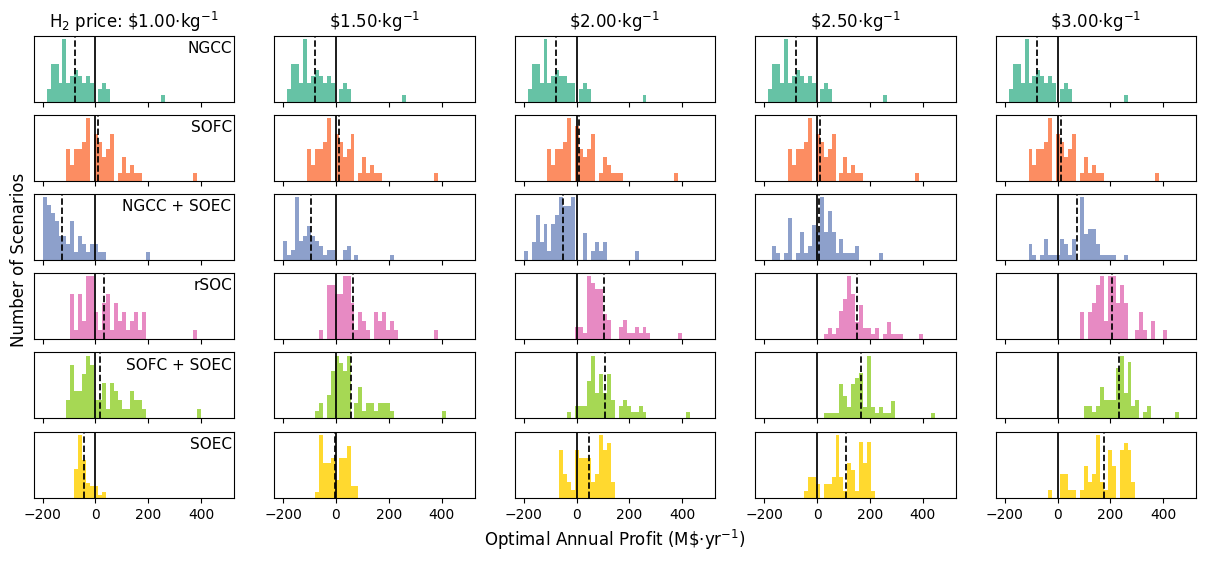

In [9]:
h2_prices = [1.0, 1.5, 2.0, 2.5, 3.0]

fig, axes = plt.subplots(6, 5, sharex=True, figsize = (15, 6))

my_bins = np.arange(-200, 500, 15)

for j, price in enumerate(h2_prices):
    # Using colors easier on the eyes
    colors = iter([plt.cm.Set2(i) for i in range(7)])
    for i in range(6):
        # Iterate over all operating modes with color coating for each equipment type
        mode = operating_modes[i]
        total_frame[mode].loc[total_frame['Hydrogen Price'] == price].hist(ax=axes[i, j], bins=my_bins, grid=False, color=[next(colors)], label=mode)
        mean = total_frame[mode].loc[total_frame['Hydrogen Price'] == price].mean()

        # Get maximum values of x, y for labeling
        _, ymax = axes[i, j].get_ylim()
        _, xmax = axes[i, j].get_xlim()

        # Create label on first coloumn for technologies
        str_len = len(mode)
        if j == 0:
            axes[i, j].text(xmax - 5 - 0.5*str_len, ymax*0.935, mode, ha='right', va='top', fontsize=11)#, weight='bold')#, transform=axes[i].transAxes)

        # Remove yticks
        axes[i, j].set_yticks([])

        # Add verticle line for the "break-even" point to each histogram
        axes[i, j].axvline(mean, color='k', linestyle='dashed', linewidth=1.25)
        axes[i, j].axvline(0, color='k', linewidth=1.25)

        # Add title in the middle of the y-axis (approximately)
        if i == 3 and j == 0:
            axes[i, j].set_ylabel('Number of Scenarios', ha='left', y=-0.1, fontsize=12)

    # Add titles for each hydrogen price. First column has the "H2 price:" label
    if j == 0:
        axes[0, j].set_title(r'H$_2$ price: \${:.2f}'.format(price) + r'$\cdot$kg$^{-1}$')
    else:
        axes[0, j].set_title(r'\${:.2f}'.format(price) + r'$\cdot$kg$^{-1}$')

# Add x-axis label in the middle (approximately)
axes[-1, 2].set_xlabel(r'Optimal Annual Profit (M\$$\cdot$yr$^{-1}$)', fontsize=12)

# Save the figure
figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "H2_all_profits_histograms_final.png"))
plt.savefig(figure_path, format='png', dpi=450)

# Line graph comparison

Various line graphs to compare/contrast inputs and results. Two major line graphs are shown:

    1. Market scenario summary
    2. Optimal profit summary 
    
Further description included above each cell.

## Market scenario summary

Plotting the Mean LMP, Natural Gas Price, and both multimodality tests for each scenario. A line is drawn on the multimodality tests to indicate that if BOTH lines are above the black line at 1.0, then the market was considered to be "multimodal" or "bimodal".

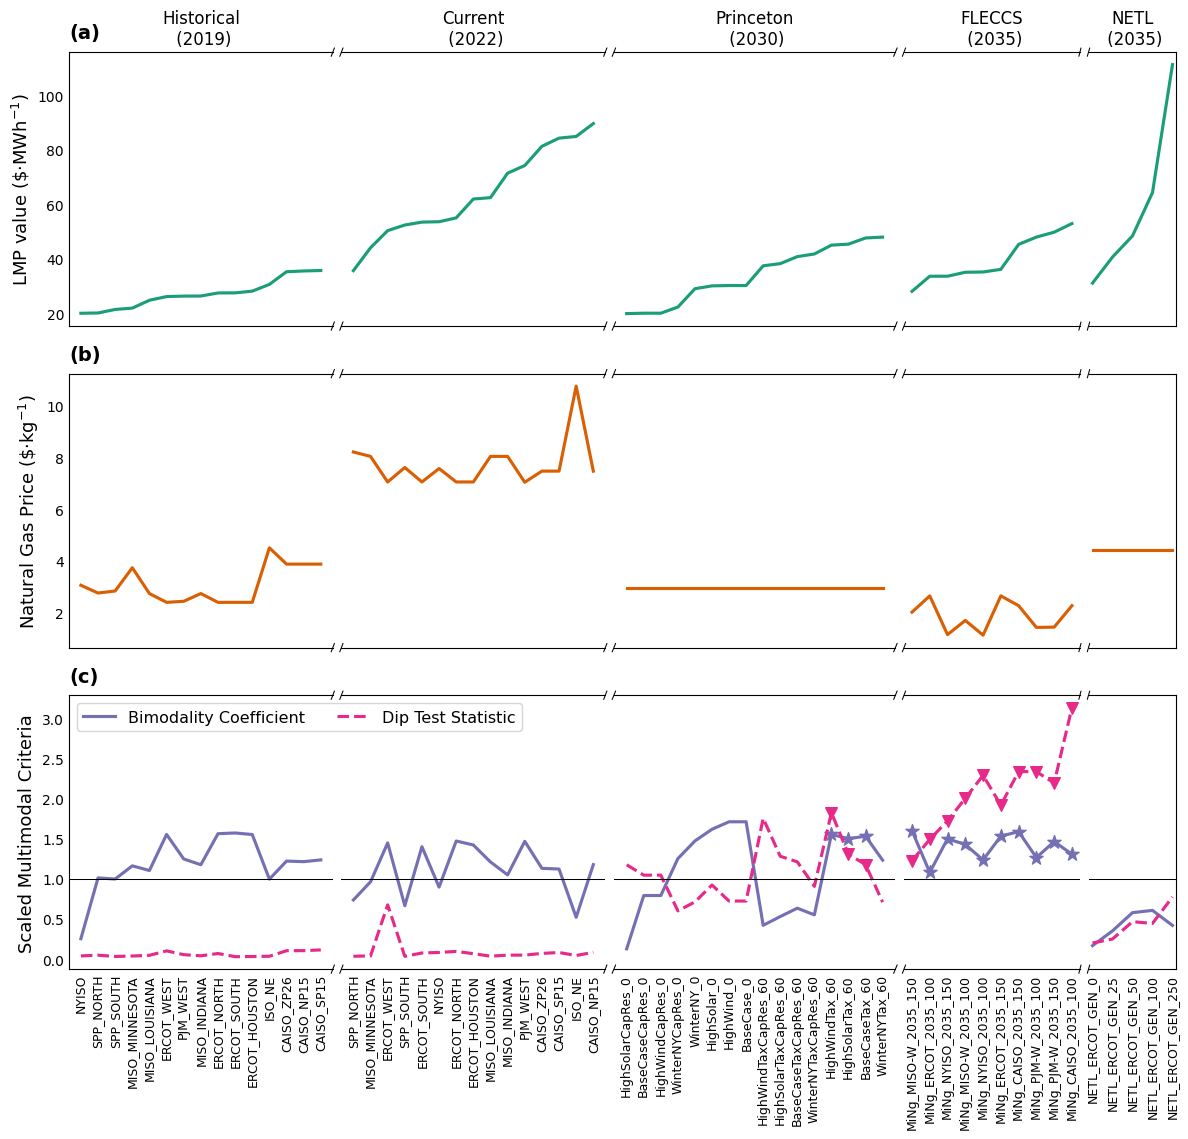

In [10]:
# Plotting all capacity things at the same time
ylabels = [r'LMP value (\$$\cdot$MWh$^{-1}$)', r'Natural Gas Price (\$$\cdot$kg$^{-1}$)', 'Scaled Multimodal Criteria']
abc_labels = {0: '(a)', 1: '(b)', 2: '(c)'}

fig, axes = plt.subplots(3, 5, sharey='row', sharex='col', figsize = (12, 11.5), width_ratios=[15, 15, 16, 10, 5])

for i in range(5):
    colors = iter([plt.cm.Dark2(m) for m in range(7)])
    for ind_k, k in enumerate(['Mean LMP', 'Natural Gas Price', ['Bimodality Coefficient', 'Dip Test Statistic']]):
        temp_vals = total_frame.sort_values('Mean LMP').loc[(total_frame['Hydrogen Price'] == 2.0) & (total_frame['Reference'] == (i + 1))]

        # Bimodality markets require two lines to be plotted
        if ind_k == 2:
            color1 = next(colors)
            color2 = next(colors)
            axes[ind_k, i].plot(range(len(temp_vals[k[0]].values)), temp_vals[k[0]].values / 0.555, color=color1, ls='solid', lw=2.25, label=k[0])
            axes[ind_k, i].plot(range(len(temp_vals[k[1]].values)), temp_vals[k[1]].values / 0.05, color=color2, ls='--', lw=2.25, label=k[1])

            # Add markers for the multimodal markets
            count = 0
            for name in temp_vals['Name']:
                if len(temp_vals[(temp_vals['Name'] == name) & (temp_vals['Passes both tests. Bimodal.'] == 1)]) > 0:
                    axes[ind_k, i].scatter(count, temp_vals[k[0]].values[count] / 0.555, color=color1, marker='*', s=100)
                    axes[ind_k, i].scatter(count, temp_vals[k[1]].values[count] / 0.05, color=color2, marker='v', s=70)
                count += 1
        else:
            axes[ind_k, i].plot(range(len(temp_vals[k].values)), temp_vals[k].values, color=next(colors), ls='solid', lw=2.25)
        
        axes[ind_k, i].tick_params(axis='both', which='both', length=0)
        
        tick_labels = [new_labels[i] for i in temp_vals['Name'].values]
        axes[ind_k, i].set_xticks(range(len(tick_labels)), tick_labels, rotation=90, fontsize=9)

        # Add y-axis labels
        if i == 0:
            axes[ind_k, i].set_ylabel(ylabels[ind_k], fontsize=13)
    
        # Add (a), (b), (c) to the top left of the figures
        if i == 0:
            axes[ind_k, i].annotate(abc_labels[ind_k], xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')
        
        # Adding spines for "disjointed" axes.
        if i < 4:
            axes[ind_k, i].annotate('', xy=(0.99, .975), xycoords='axes fraction', xytext=(1.01, 1.025), 
                                arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            axes[ind_k, i].annotate('', xy=(0.99, -0.025), xycoords='axes fraction', xytext=(1.01, .025), 
                                arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            axes[ind_k, i].spines['right'].set_visible(False)
        if i > 0:
            if i == 4:
                # NETL data small so the axis break looks weird
                axes[ind_k, i].annotate('', xy=(-0.0225, .975), xycoords='axes fraction', xytext=(.0225, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(-0.0225, -0.025), xycoords='axes fraction', xytext=(.0225, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            elif i == 3:
                # FLECCS data small so the axis break looks weird
                axes[ind_k, i].annotate('', xy=(-0.015, .975), xycoords='axes fraction', xytext=(0.015, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(-0.015, -0.025), xycoords='axes fraction', xytext=(0.015, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            else:
                axes[ind_k, i].annotate('', xy=(-0.01, .975), xycoords='axes fraction', xytext=(.01, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(-0.01, -0.025), xycoords='axes fraction', xytext=(.01, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            axes[ind_k, i].spines['left'].set_visible(False)

        # Adding bimodality pass line for the bimodality tests.
        if ind_k == 2:
            axes[ind_k, i].axhline(1.0, color='k', linewidth=0.75)

        # Adding market scenario reference/source titles
        if ind_k == 0:
            axes[ind_k, i].set_title(dataset_titles[(i + 1)], fontsize=12)


axes[2, 0].set_zorder(1)
axes[2, 0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=11.5)

figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "market_statistics.png"))

plt.tight_layout()
fig.subplots_adjust(wspace=0.04)
plt.savefig(figure_path, format='png', dpi=450)

## Optimal Annual Profit Summary

Line graph of all scenarios for each technology at a hydrogen price of $2.00/kg. The scenarios are separated by data source (i.e., historical (2018), current (2022), Princeton (2030), FLECCS (2035), NETL (2035)) and sorted within each data source by the optimal SOFC profit for the given year-long LMP signal.

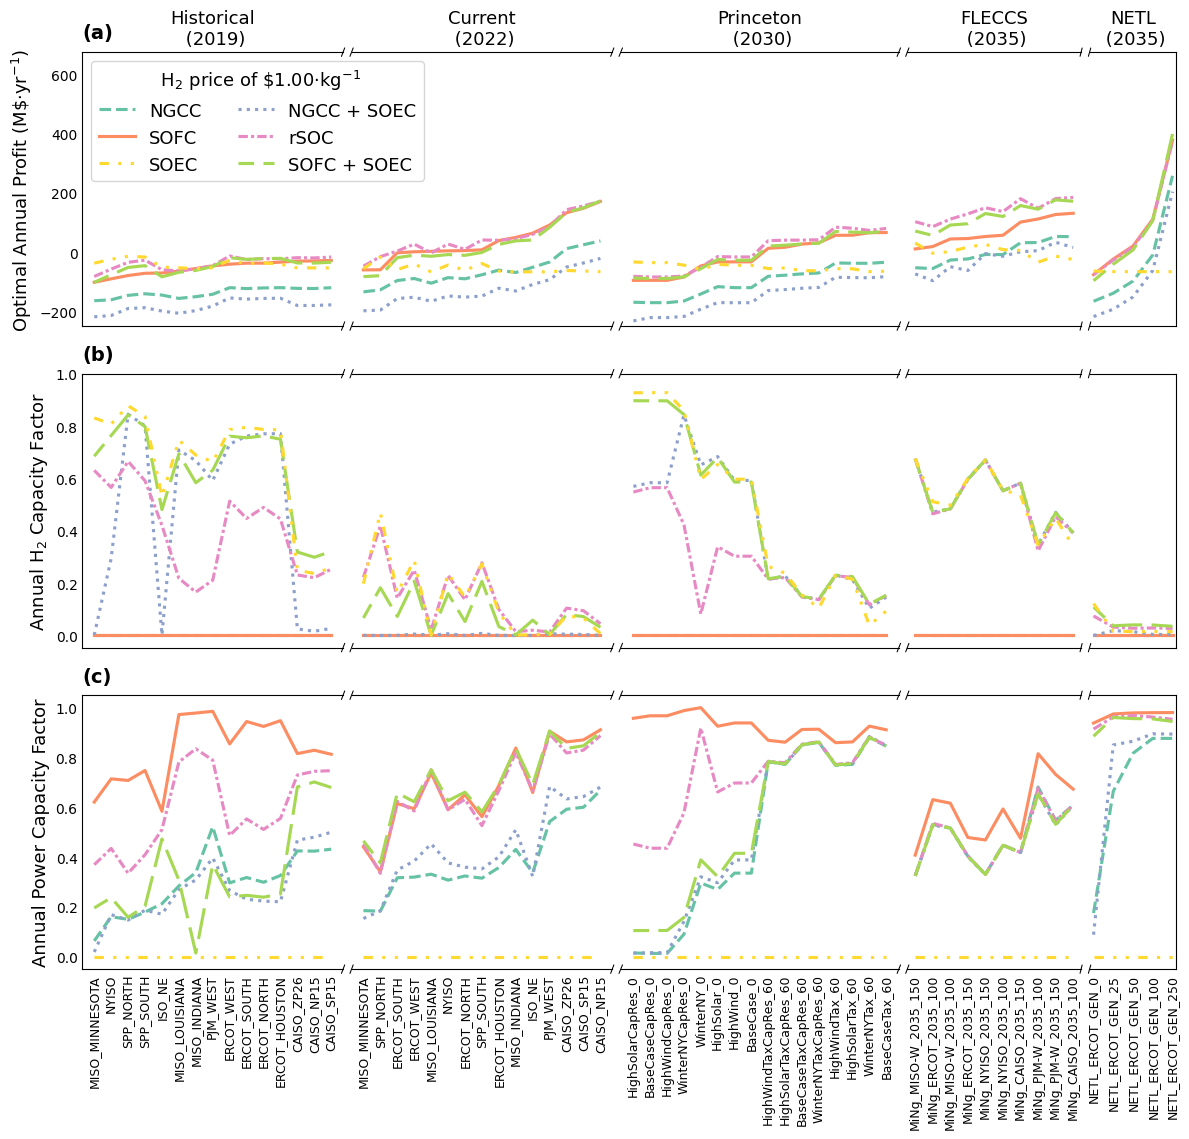

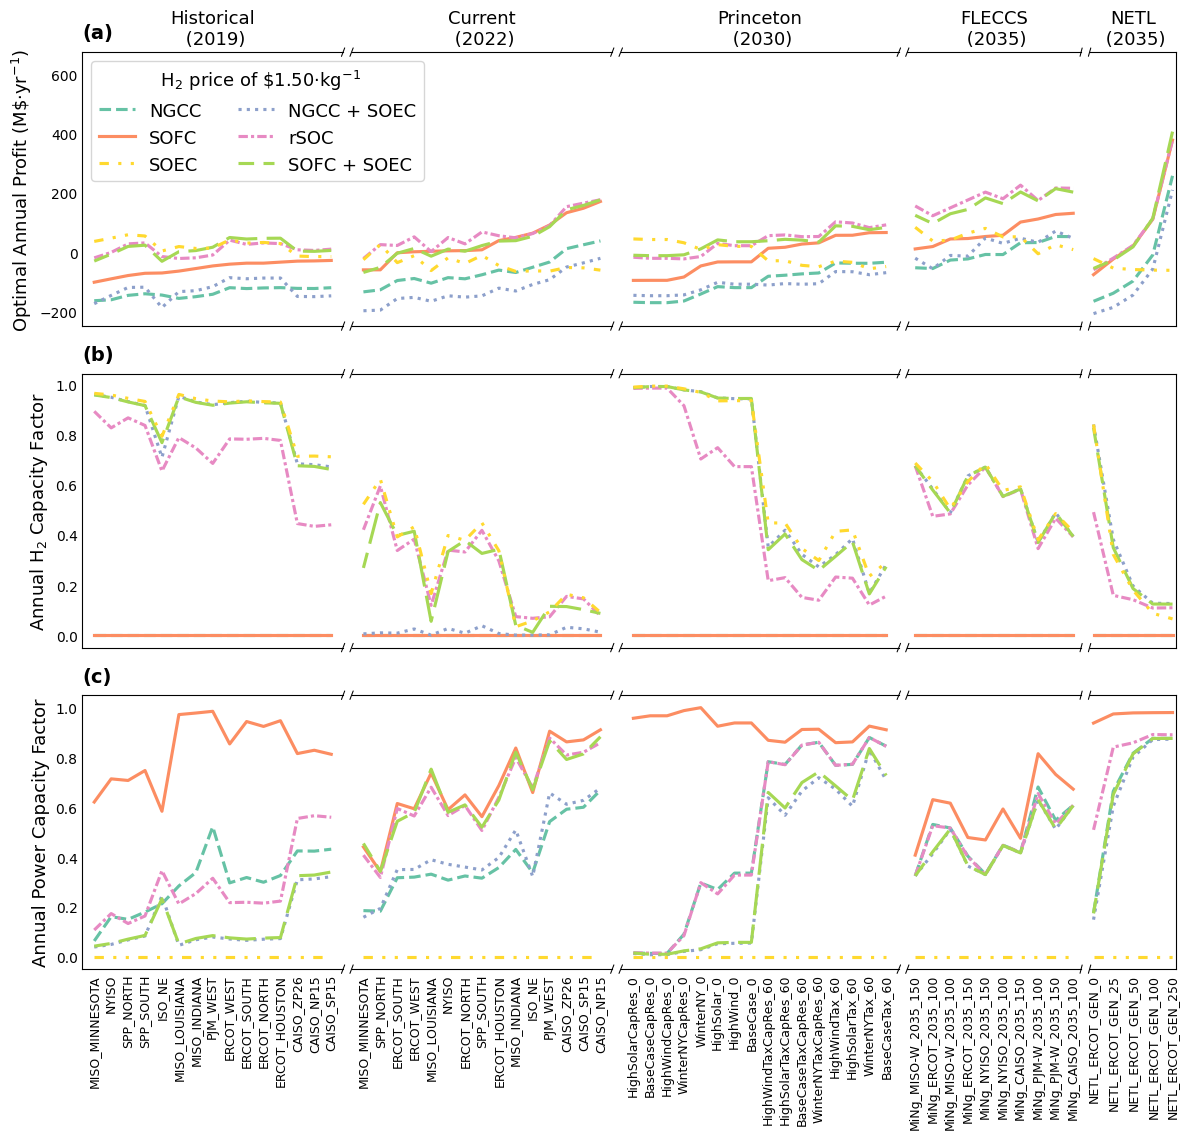

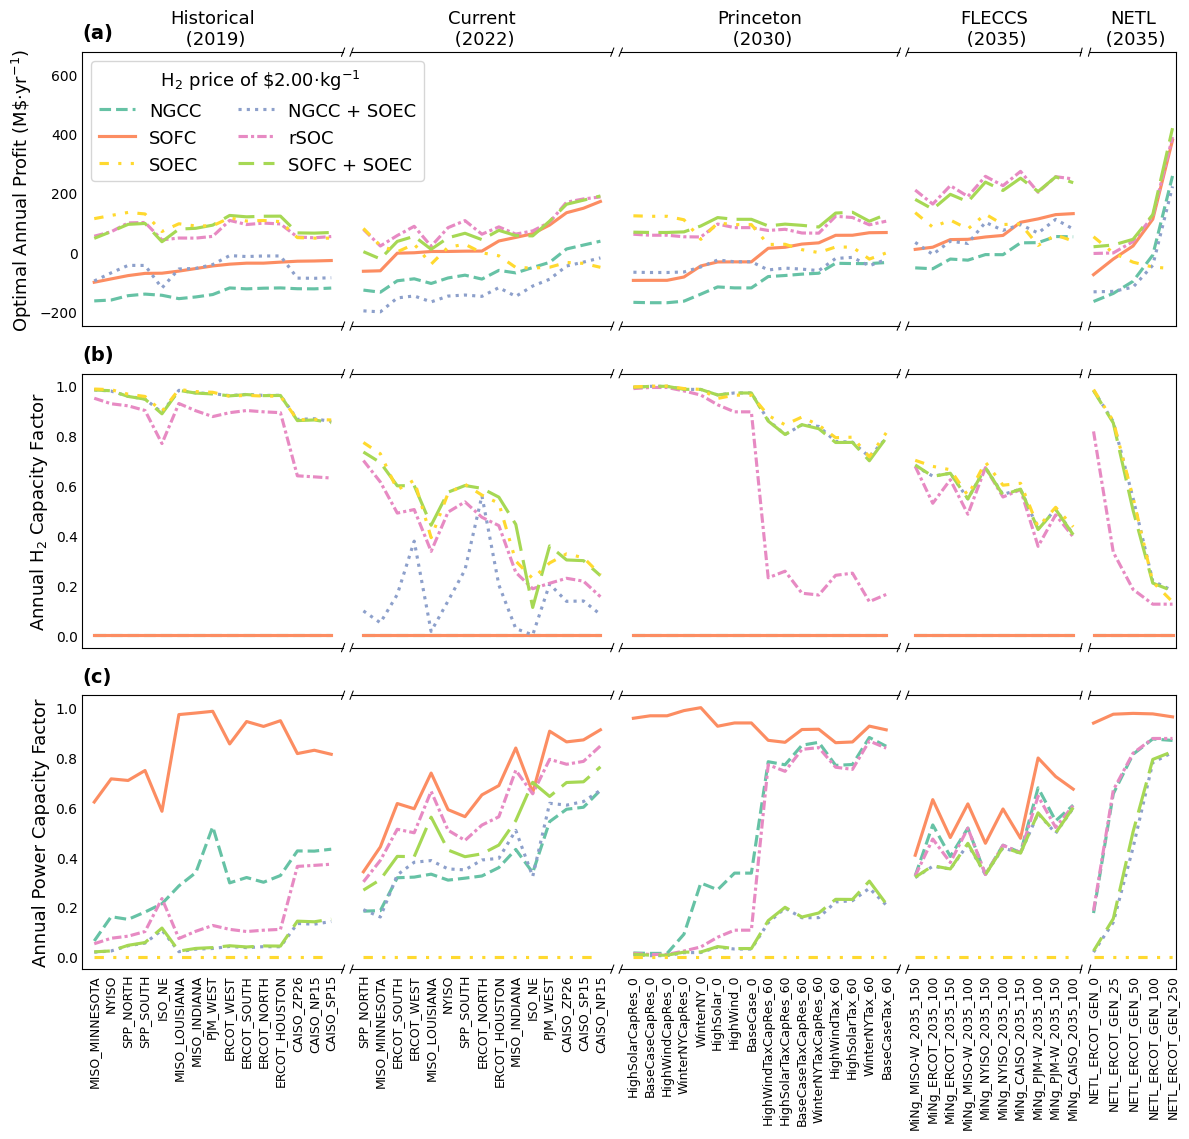

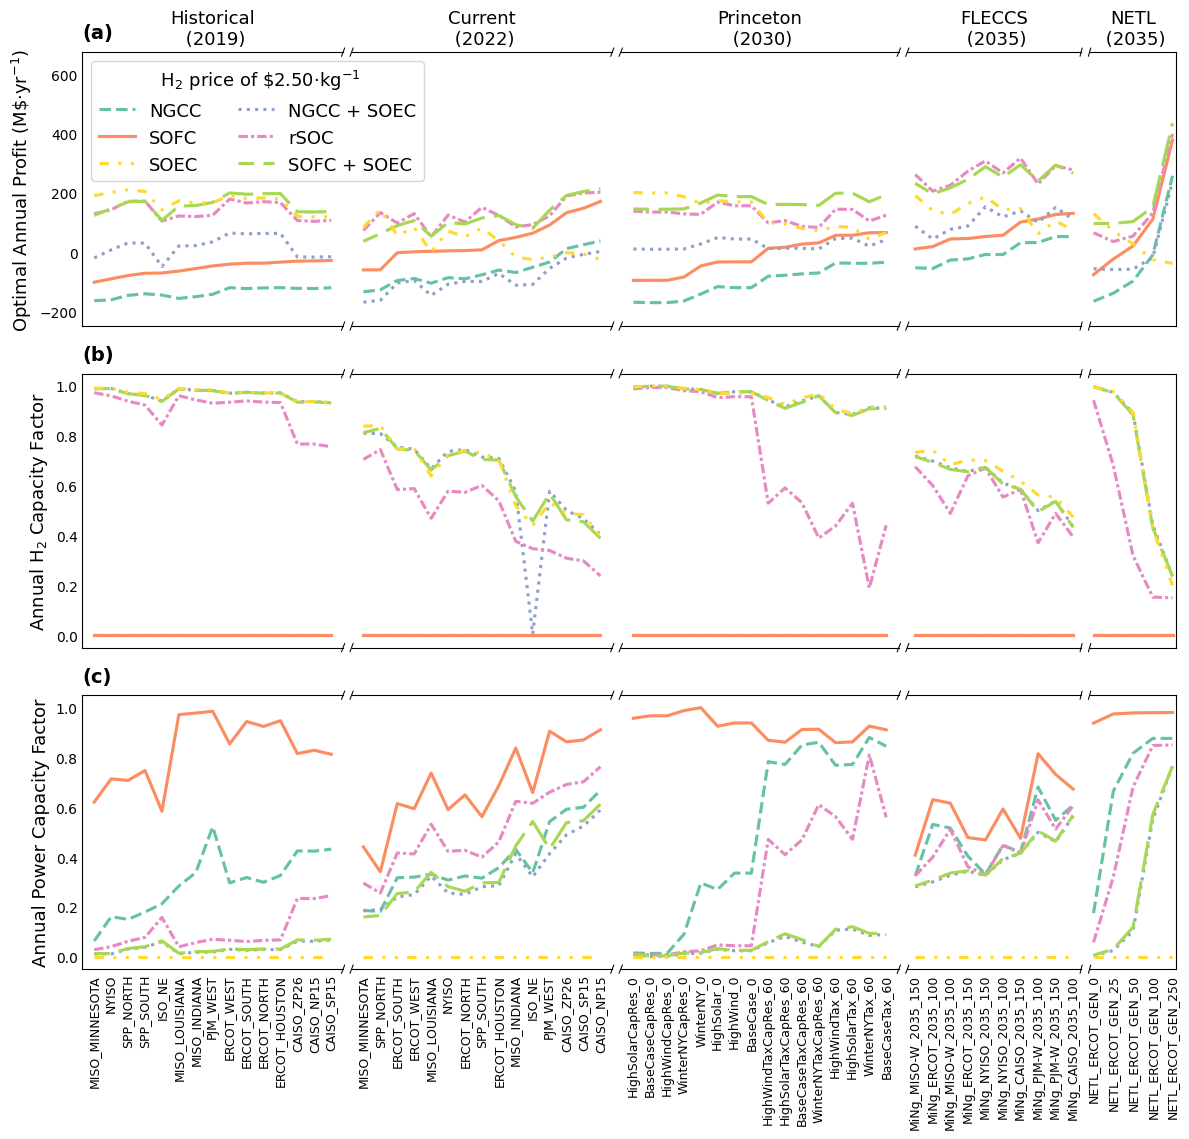

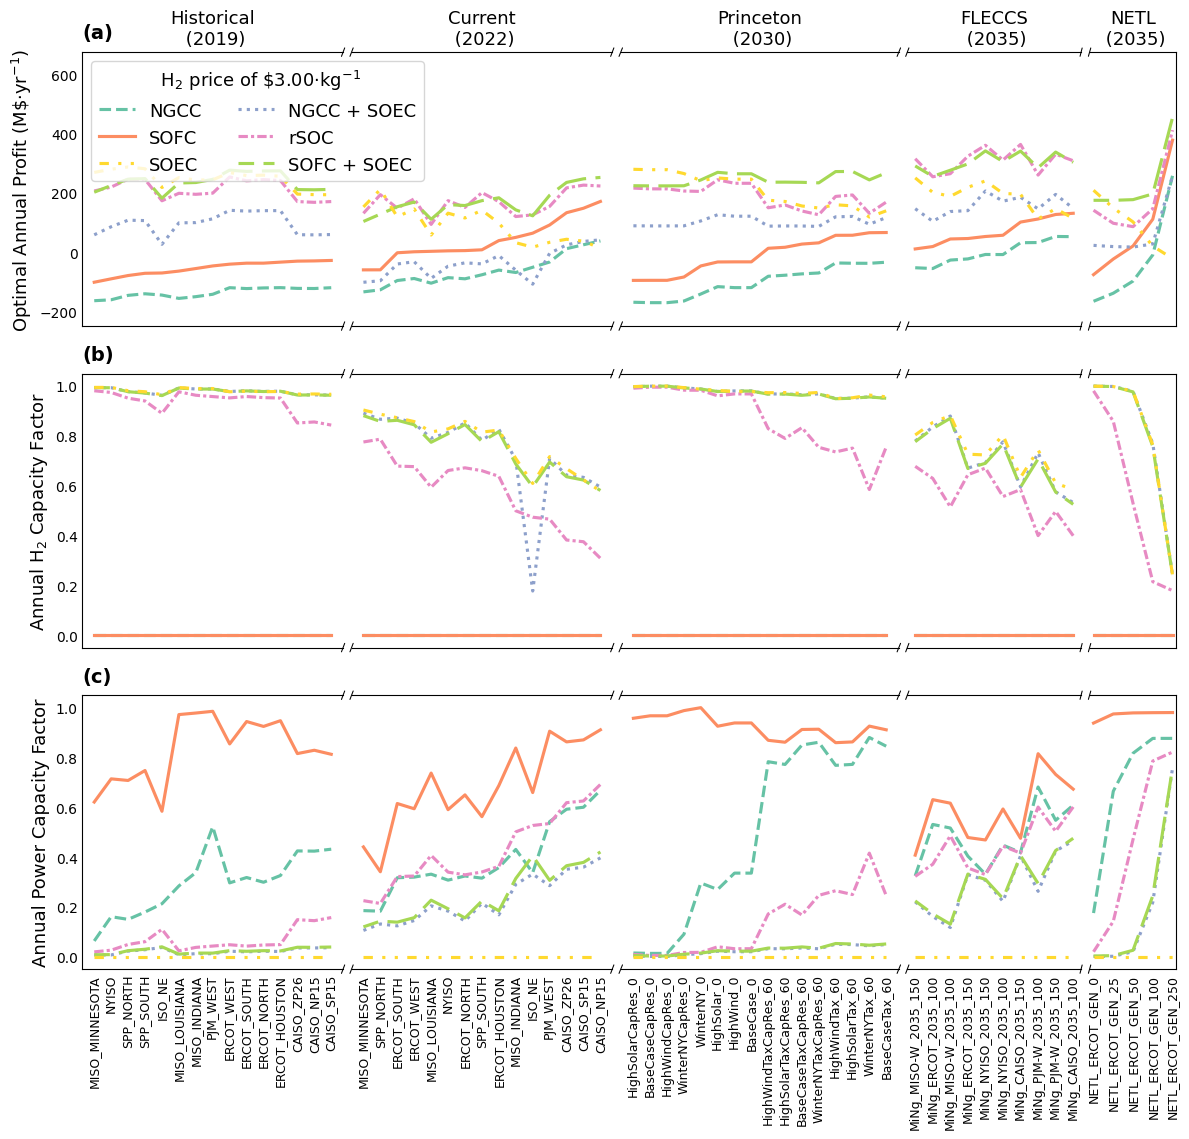

In [11]:
# Plotting all capacity things at the same time
prices = [1.0, 1.5, 2.0, 2.5, 3.0]
labels = [[1, 0], [1, 5], [2, 0], [2, 5], [3, 0]]

ylabels = [r'Optimal Annual Profit (M\$$\cdot$yr$^{-1}$)', r'Annual H$_2$ Capacity Factor', r'Annual Power Capacity Factor']
abc_labels = {0: '(a)', 1: '(b)', 2: '(c)'}

for ind, price in enumerate(prices):
    # Plotting for each hydrogen price
    fig, axes = plt.subplots(3, 5, sharey='row', sharex='col', figsize = (12, 11.5), width_ratios=[15, 15, 16, 10, 5])
    linestyles = {'SOFC': 'solid', 
                  'NGCC': '--', 
                  'NGCC + SOEC': ':', 
                  'SOFC + SOEC': (5, (10, 3)), 
                  'SOEC': (0, (3, 3, 1, 3, 1, 3)), 
                  'rSOC': (0, (3, 1, 1, 1))}
    
    
    for i in range(5):
        for ind_k, k in enumerate(['', '_H2', '_power']):
            colors = iter([plt.cm.Set2(k) for k in range(7)])
            for j in range(6):
                mode_only = operating_modes[j]
                mode = operating_modes[j] + k
                temp_vals = total_frame.sort_values('SOFC').loc[(total_frame['Hydrogen Price'] == price) & (total_frame['Reference'] == (i + 1))]
                
                axes[ind_k, i].plot(range(len(temp_vals[mode].values)), temp_vals[mode].values, color=next(colors), ls=linestyles[mode_only], lw=2.25, label=mode)
                axes[ind_k, i].tick_params(axis='both', which='both', length=0)

                # Axes shifted so the higher hydrogen price legend doesn't block the figure data.
                axes[0, i].set_ylim([-250, 675])

            # Renaming the x-axis with price signal names
            tick_labels = [new_labels[i] for i in temp_vals['Name'].values]
            axes[ind_k, i].set_xticks(range(len(tick_labels)), tick_labels, rotation=90, fontsize=9)

            # Adding labels for y-axis
            if i == 0:
                axes[ind_k, i].set_ylabel(ylabels[ind_k], fontsize=13)

            # Adding (a), (b), (c) labels for figure panels
            if i == 0:
                axes[ind_k, i].annotate(abc_labels[ind_k], xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')
            
            # Adding spines for the disjointed plots
            if i < 4:
                axes[ind_k, i].annotate('', xy=(0.99, .975), xycoords='axes fraction', xytext=(1.01, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(0.99, -0.025), xycoords='axes fraction', xytext=(1.01, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].spines['right'].set_visible(False)
            if i > 0:
                if i == 4:
                    # NETL data small so the axis break looks weird
                    axes[ind_k, i].annotate('', xy=(-0.0225, .975), xycoords='axes fraction', xytext=(.0225, 1.025), 
                                        arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                    axes[ind_k, i].annotate('', xy=(-0.0225, -0.025), xycoords='axes fraction', xytext=(.0225, .025), 
                                        arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                elif i == 3:
                    # FLECCS data small so the axis break looks weird
                    axes[ind_k, i].annotate('', xy=(-0.015, .975), xycoords='axes fraction', xytext=(0.015, 1.025), 
                                        arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                    axes[ind_k, i].annotate('', xy=(-0.015, -0.025), xycoords='axes fraction', xytext=(0.015, .025), 
                                        arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                else:
                    axes[ind_k, i].annotate('', xy=(-0.01, .975), xycoords='axes fraction', xytext=(.01, 1.025), 
                                        arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                    axes[ind_k, i].annotate('', xy=(-0.01, -0.025), xycoords='axes fraction', xytext=(.01, .025), 
                                        arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].spines['left'].set_visible(False)
            if ind_k == 0:
                axes[ind_k, i].set_title(dataset_titles[(i + 1)], fontsize=13)

    
    axes[1, 0].ylim = [0, 1]
    axes[2, 0].ylim = [0, 1]
    axes[1, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes[2, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes[0, 0].set_zorder(1)
    # Reordering legend to be the same order as figure 1 (technology summary)
    objs, leg_labels = axes[0, 0].get_legend_handles_labels()
    new_order = [0, 2, 1, 4, 3, 5]
    new_order = [0, 1, 5, 2, 3, 4]
    legend = axes[0, 0].legend([objs[ind_obj] for ind_obj in new_order], [leg_labels[ind_obj] for ind_obj in new_order], 
                               loc='upper left', title=r' H$_2$ price of \${}.{}0'.format(labels[ind][0], labels[ind][1]) + r'$\cdot$kg$^{-1}$', 
                               bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=13)
    plt.setp(legend.get_title(), fontsize=13)

    figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "SI", "H2_{}_dollar_all_line_graphs.png".format(int(10*price))))

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.04)
    plt.savefig(figure_path, format='png', dpi=450)

# Bimodal Comparison SOFC vs. SOFC + SOEC

Two figures. One is a two-panel scatter plot to show that the bimodal cases (more specifically those predicted by FLECCS with high VRES contribution) lead to higher profits, not following the general trend of "higher LMP, lower H2 production feasibility".

Second figure is another two-panel figure with a comparison of how SOEC+SOFC outperforms SOEC or SOFC individually with histograms.

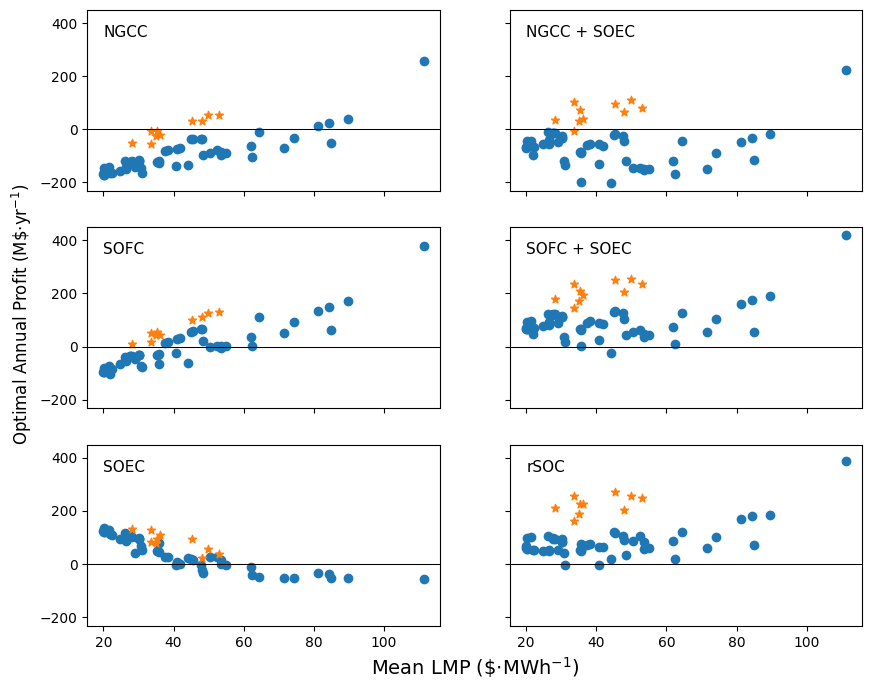

In [12]:
fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize = (10, 8))

bimodal_LMPs = ['BaseCaseTax_60_2030',  
                'HighWindTax_60_2030', 
                'HighSolarTax_60_2030']

for i in total_frame[total_frame['Reference'] == 4]['Name'].values:
    bimodal_LMPs.append(i)

nonbimodal_color = 'tab:blue'
# ND Blue
# nonbimodal_color = (12 / 255, 35 / 255, 64 / 255, 1)
bimodal_color = 'tab:orange'
# ND Metallic Gold
# bimodal_color = (174 / 255, 143 / 255, 64 / 255, 1)
nonbimodal_marker = 'o'
bimodal_marker = '*'

new_operating_modes = ['NGCC', 'NGCC + SOEC',
                       'SOFC', 'SOFC + SOEC', 
                       'SOEC', 'rSOC']

count = 0
for i in range(3):
    for j in range(2):
        mode = new_operating_modes[count]
        count += 1
        # Plot nonbimodal LMPs
        # Change back to '50th Percentile' for median LMP if desired
        axes[i, j].scatter(total_frame.loc[(total_frame['Hydrogen Price'] == 2.0) & (~total_frame['Name'].isin(bimodal_LMPs))]['Mean LMP'], 
                        total_frame.loc[(total_frame['Hydrogen Price'] == 2.0) & (~total_frame['Name'].isin(bimodal_LMPs))][mode], 
                        color=nonbimodal_color, marker=nonbimodal_marker, label='Nonbimodal LMPs')
        
        # Plot bimodal LMPs
        axes[i, j].scatter(total_frame.loc[(total_frame['Hydrogen Price'] == 2.0) & (total_frame['Name'].isin(bimodal_LMPs))]['Mean LMP'], 
                        total_frame.loc[(total_frame['Hydrogen Price'] == 2.0) & (total_frame['Name'].isin(bimodal_LMPs))][mode], 
                        color=bimodal_color, marker=bimodal_marker, label='Bimodal LMPs')

        # Need x, y position to place the technology types
        str_len = len(mode)
        _, ymax = axes[i, j].get_ylim()
        _, xmax = axes[i, j].get_xlim()
        ymax = 420
        xycoords='axes fraction'
        
        # Make -2.5 for x position if using '50th Percentile'
        axes[i, j].text(20, ymax*0.935, mode, ha='left', va='top', fontsize=11)

        # Adding break-even line
        axes[i, j].axhline(0, color='k', linewidth=0.75)

        # Add x and y axis labels in the middle (approximately)
        if i == 1 and j == 0:
            axes[i, j].set_ylabel(r'Optimal Annual Profit (M\$$\cdot$yr$^{-1}$)', y =-0.2, ha='left', fontsize=12)
        if i == 2  and j == 0:
            axes[i, j].set_xlabel(r'Mean LMP (\$$\cdot$MWh$^{-1}$)', x=1.1, fontsize=14)


figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "SOEC_vs_SOFC_plus_SOEC_bimodal_scatter_mean.png"))

plt.savefig(figure_path, format='png', dpi=450)

# Histogram for profit difference from integration

Histogram of profit difference from the integrated technology versus the original technology.

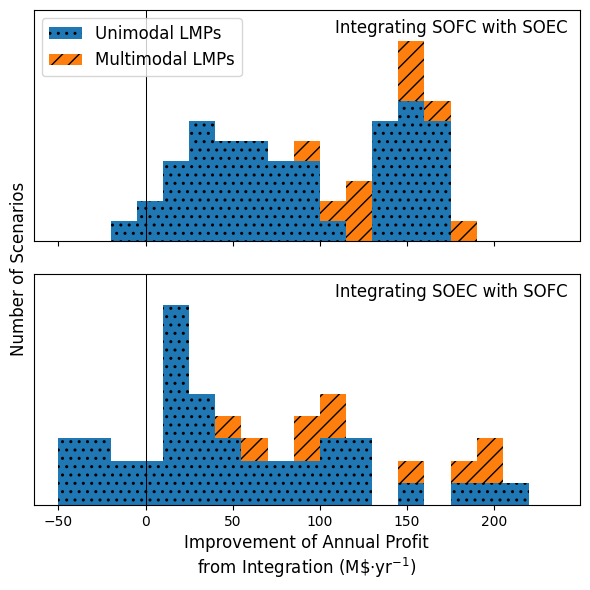

In [13]:
price = 2.0

fig, axes = plt.subplots(2, 1, sharex=True, figsize = (6, 6))

my_bins = np.arange(-50, 250, 15)
colors = iter([plt.cm.Set2(i) for i in range(7)])


my_op_modes = ['SOFC', 'SOEC']

for i in range(2):
    price = 2.0
    hatches = ['..', '//']
    mode = my_op_modes[i]
    other_mode = my_op_modes[-(i+1)]
    mode_label = 'Integrating {} with {}'.format(mode, other_mode)

    frame_at_price = total_frame.loc[total_frame['Hydrogen Price'] == price]
    
    frame_unimodal = frame_at_price.loc[~frame_at_price['Name'].isin(bimodal_LMPs)]
    frame_bimodal = frame_at_price.loc[frame_at_price['Name'].isin(bimodal_LMPs)]

    opt_profit_unimodal = (frame_unimodal['SOFC + SOEC'] - frame_unimodal[mode]).values
    opt_profit_bimodal = (frame_bimodal['SOFC + SOEC'] - frame_bimodal[mode]).values
    
    n, bins, patches = axes[i].hist([opt_profit_unimodal, opt_profit_bimodal], bins=my_bins, 
                                    color=[nonbimodal_color, bimodal_color], label=['Unimodal LMPs', 'Multimodal LMPs'],
                                    stacked=True, density=True)
    count = 0
    for patch_set, hatch in zip(patches, hatches):
        for patch in patch_set.patches:
            patch.set_hatch(hatch)
        count += 1
    
    
    _, ymax = axes[i].get_ylim()
    _, xmax = axes[i].get_xlim()

    axes[i].set_ylim([0, ymax*1.1])
    ymax=ymax*1.1
    
    str_len = len(mode)
    
    axes[i].text(xmax - 5 - 0.5*str_len, ymax * 0.96, mode_label, ha='right', va='top', fontsize=12)#, transform=axes[i].transAxes)
    axes[i].set_yticks([])

    axes[i].axvline(0, color='k', linewidth=0.75)
    
    if i == 0:
        # axes[i].legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)
        axes[i].legend(loc=2, fontsize=12)
        axes[i].set_ylabel('Number of Scenarios', ha='left', y=-0.5, fontsize=12)

axes[-1].set_xlabel('Improvement of Annual Profit\n' + r'from Integration (M\$$\cdot$yr$^{-1}$)', fontsize=12)

figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "Integration_benefit_SOFC_SOEC_vs_combined_H2_2.png"))

plt.tight_layout()
plt.savefig(figure_path, format='png', dpi=450)

## SI Figure of above, but with NGCC and SOEC

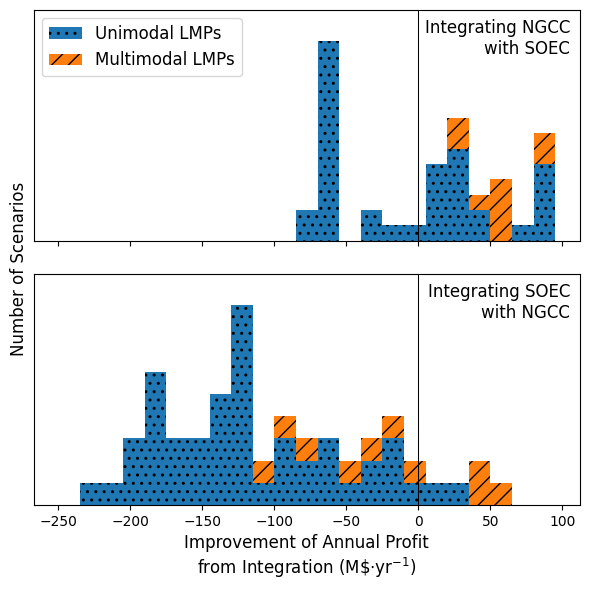

In [14]:
price = 2.0

fig, axes = plt.subplots(2, 1, sharex=True, figsize = (6, 6))

my_bins = np.arange(-250, 100, 15)
colors = iter([plt.cm.Set2(i) for i in range(7)])


my_op_modes = ['NGCC', 'SOEC']

for i in range(2):
    price = 2.0
    hatches = ['..', '//']
    mode = my_op_modes[i]
    other_mode = my_op_modes[-(i+1)]
    mode_label = 'Integrating {}\nwith {}'.format(mode, other_mode)

    frame_at_price = total_frame.loc[total_frame['Hydrogen Price'] == price]
    
    frame_unimodal = frame_at_price.loc[~frame_at_price['Name'].isin(bimodal_LMPs)]
    frame_bimodal = frame_at_price.loc[frame_at_price['Name'].isin(bimodal_LMPs)]

    opt_profit_unimodal = (frame_unimodal['NGCC + SOEC'] - frame_unimodal[mode]).values
    opt_profit_bimodal = (frame_bimodal['NGCC + SOEC'] - frame_bimodal[mode]).values
    
    n, bins, patches = axes[i].hist([opt_profit_unimodal, opt_profit_bimodal], bins=my_bins, 
                                    color=[nonbimodal_color, bimodal_color], label=['Unimodal LMPs', 'Multimodal LMPs'],
                                    stacked=True, density=True)
    count = 0
    for patch_set, hatch in zip(patches, hatches):
        for patch in patch_set.patches:
            patch.set_hatch(hatch)
        count += 1
    
    
    _, ymax = axes[i].get_ylim()
    _, xmax = axes[i].get_xlim()

    axes[i].set_ylim([0, ymax*1.1])
    ymax=ymax*1.1
    
    str_len = len(mode)
    
    axes[i].text(xmax - 5 - 0.5*str_len, ymax * 0.96, mode_label, ha='right', va='top', fontsize=12)#, transform=axes[i].transAxes)
    axes[i].set_yticks([])

    axes[i].axvline(0, color='k', linewidth=0.75)
    
    if i == 0:
        # axes[i].legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)
        axes[i].legend(loc=2, fontsize=12)
        axes[i].set_ylabel('Number of Scenarios', ha='left', y=-0.5, fontsize=12)

axes[-1].set_xlabel('Improvement of Annual Profit\n' + r'from Integration (M\$$\cdot$yr$^{-1}$)', fontsize=12)

figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "SI", "Integration_benefit_NGCC_SOEC_vs_combined_H2_2.png"))

plt.tight_layout()
plt.savefig(figure_path, format='png', dpi=450)

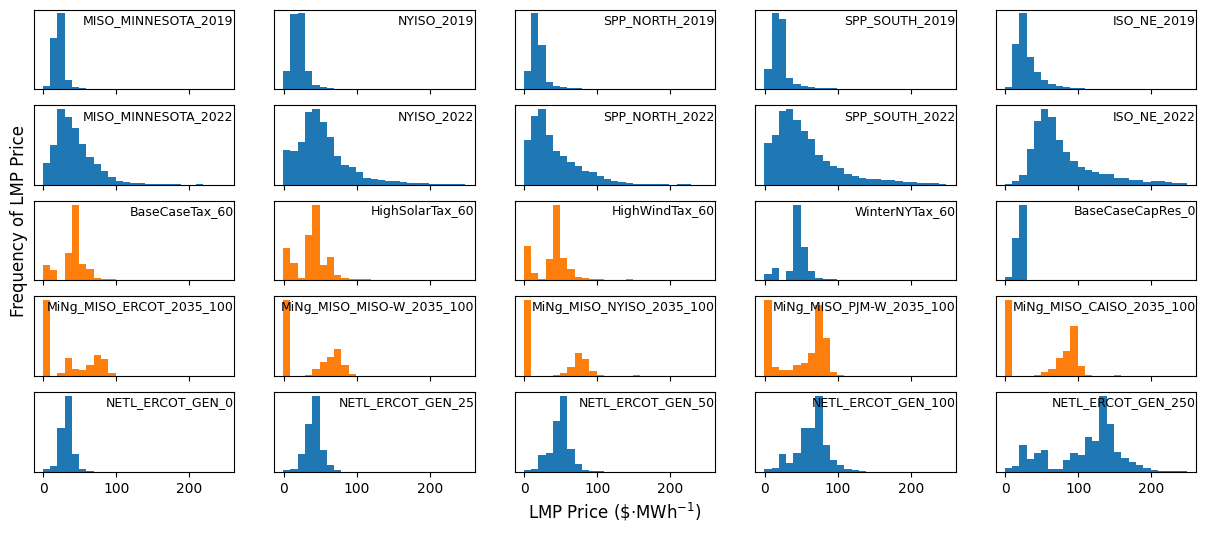

In [15]:
# Reading in the LMP data
file_name_lmp = os.path.abspath(os.path.join(current_dir, "..", "data", "lmp_data.csv"))
lmp_data = pd.read_csv(file_name_lmp)

renaming_dict = {"MiNg_$100_ERCOT_2035" : 'MiNg_MISO_ERCOT_2035_100',
                 "MiNg_$100_MISO-W_2035": 'MiNg_MISO_MISO-W_2035_100',
                 "MiNg_$100_NYISO_2035": 'MiNg_MISO_NYISO_2035_100',
                 "MiNg_$100_PJM-W_2035": 'MiNg_MISO_PJM-W_2035_100',
                 "MiNg_$100_CAISO_2035":  'MiNg_MISO_CAISO_2035_100',
                 'BaseCaseTax_2030' : 'BaseCaseTax_60', 
                 'HighSolarTax_2030': 'HighSolarTax_60', 
                 'HighWindTax_2030': 'HighWindTax_60', 
                 'WinterNYTax_2030': 'WinterNYTax_60', 
                 'BaseCaseCapRes_2030': 'BaseCaseCapRes_0'}
for i in renaming_dict.keys():
    lmp_data[renaming_dict[i]] = lmp_data[i]
market_names = [['MISO_MINNESOTA_2019', 'NYISO_2019', 'SPP_NORTH_2019', 'SPP_SOUTH_2019', 'ISO_NE_2019'], 
                ['MISO_MINNESOTA_2022', 'NYISO_2022', 'SPP_NORTH_2022', 'SPP_SOUTH_2022', 'ISO_NE_2022'], 
                ['BaseCaseTax_60', 'HighSolarTax_60', 'HighWindTax_60', 'WinterNYTax_60', 'BaseCaseCapRes_0'], 
                ['MiNg_MISO_ERCOT_2035_100', 'MiNg_MISO_MISO-W_2035_100', 
                 'MiNg_MISO_NYISO_2035_100', 'MiNg_MISO_PJM-W_2035_100', 
                 'MiNg_MISO_CAISO_2035_100'], 
                ['NETL_ERCOT_GEN_0', 'NETL_ERCOT_GEN_25', 
                 'NETL_ERCOT_GEN_50', 'NETL_ERCOT_GEN_100', 
                 'NETL_ERCOT_GEN_250']]

bimodal_lmps_plotting = ['MiNg_MISO_ERCOT_2035_100', 'MiNg_MISO_MISO-W_2035_100', 
                         'MiNg_MISO_NYISO_2035_100', 'MiNg_MISO_PJM-W_2035_100', 
                         'MiNg_MISO_CAISO_2035_100', 'BaseCaseTax_60', 'HighSolarTax_60', 'HighWindTax_60']

# Plotting the LMP data
my_bins_1 = np.arange(-1, 250, 10)

my_bins_2 = np.arange(-1, 1805, 15)

fig, axes = plt.subplots(5, 5, sharex=True, figsize = (15, 6))

for i in range(5):
    for j in range(5):
        ref = i + 1
        market = market_names[i][j]

        if market in bimodal_lmps_plotting:
            color = 'tab:orange'
        else:
            color = 'tab:blue'
        my_bins = my_bins_1

        lmp_data[market].hist(ax=axes[i, j], bins=my_bins, grid=False, color=color, label=market)
        # axes[i].legend()
        _, ymax = axes[i, j].get_ylim()
        _, xmax = axes[i, j].get_xlim()

        str_len = len(market)

        axes[i, j].text(xmax - 0.5*6/150*str_len, ymax * 0.95, market, ha='right', va='top', fontsize=9)#, transform=axes[i].transAxes)
        axes[i, j].set_yticks([])
    
    
        if i == 3 and j == 0:
            axes[i, j].set_ylabel('Frequency of LMP Price', ha='left', y=0.75, fontsize=12)


axes[-1, 2].set_xlabel(r'LMP Price (\$$\cdot$MWh$^{-1}$)', fontsize=12)
figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "SI", "lmp_distributions_sample.png"))

plt.savefig(figure_path, format='png', dpi=450)

# Market Scenario Summary for SI

Market scenario summary with 25/50/75 LMP quartile plotted on the first plot. The plot is now sorted by SOFC profit as to emulate the sorting in the other line graphs.

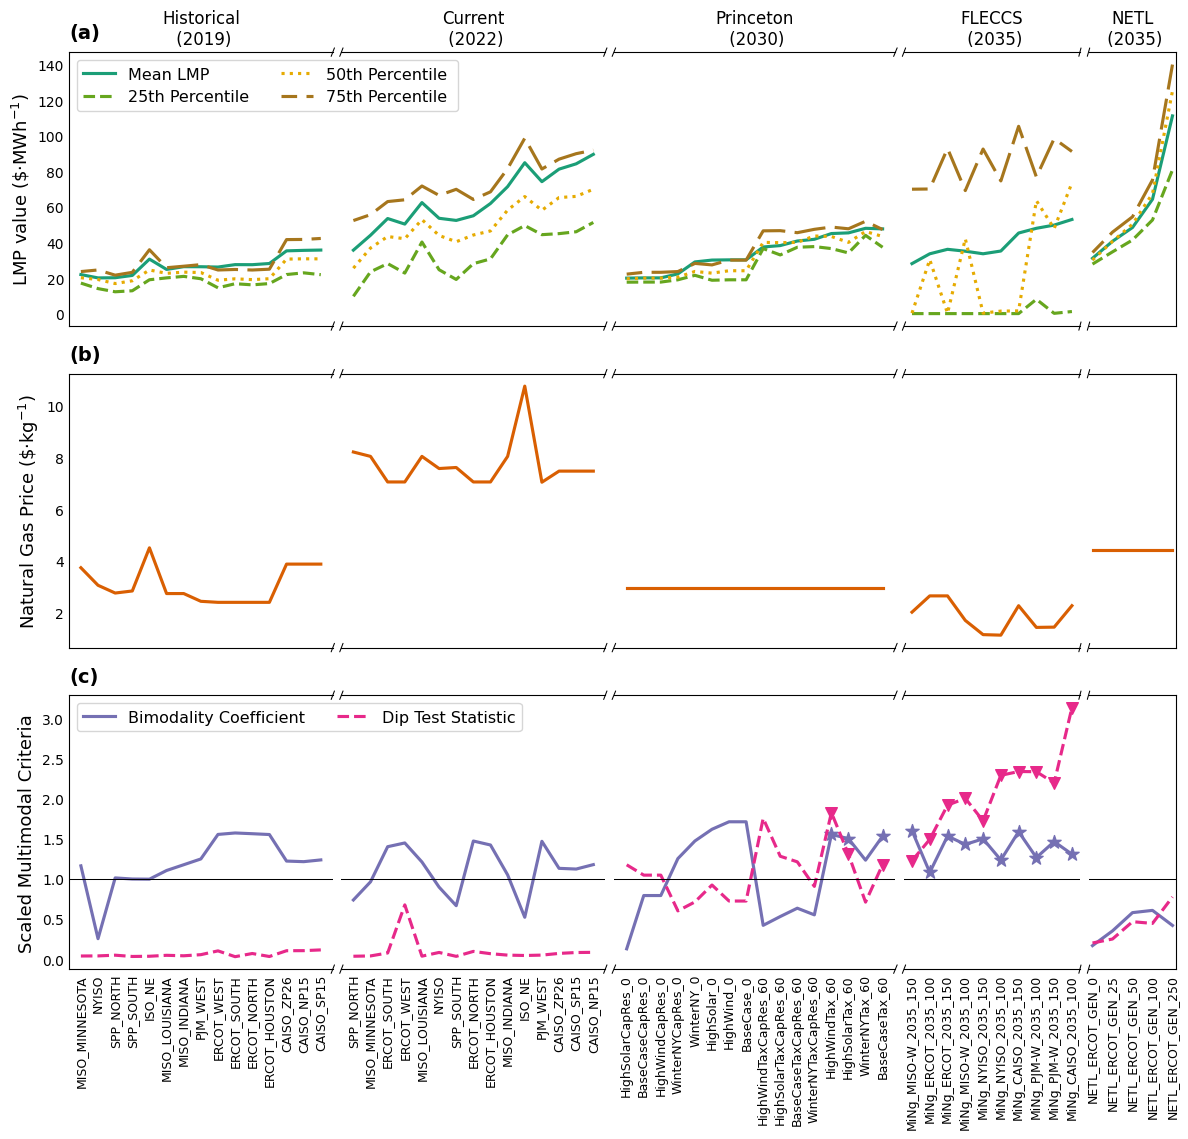

In [16]:
# Plotting all capacity things at the same time
ylabels = [r'LMP value (\$$\cdot$MWh$^{-1}$)', r'Natural Gas Price (\$$\cdot$kg$^{-1}$)', 'Scaled Multimodal Criteria']
abc_labels = {0: '(a)', 1: '(b)', 2: '(c)'}

fig, axes = plt.subplots(3, 5, sharey='row', sharex='col', figsize = (12, 11.5), width_ratios=[15, 15, 16, 10, 5])

colors = iter([plt.cm.Dark2(m) for m in range(9)])
colors_ = [color for color in colors]
colors = [colors_[0], colors_[4], colors_[5], colors_[6], 
          colors_[1], 
          colors_[2], colors_[3]]
linestyles = ['solid', '--', ':', (5, (10, 3))]

for i in range(5):
    for ind_k, k in enumerate([['Mean LMP', '25th Percentile', '50th Percentile', '75th Percentile '], 'Natural Gas Price', ['Bimodality Coefficient', 'Dip Test Statistic']]):
        temp_vals = total_frame.sort_values('SOFC').loc[(total_frame['Hydrogen Price'] == 2.0) & (total_frame['Reference'] == (i + 1))]

        # Bimodality markets require two lines to be plotted
        if ind_k == 2:
            color1 = colors[5]
            color2 = colors[6]
            axes[ind_k, i].plot(range(len(temp_vals[k[0]].values)), temp_vals[k[0]].values / 0.555, color=color1, ls='solid', lw=2.25, label=k[0])
            axes[ind_k, i].plot(range(len(temp_vals[k[1]].values)), temp_vals[k[1]].values / 0.05, color=color2, ls='--', lw=2.25, label=k[1])

            # Add markers for the multimodal markets
            count = 0
            for name in temp_vals['Name']:
                if len(temp_vals[(temp_vals['Name'] == name) & (temp_vals['Passes both tests. Bimodal.'] == 1)]) > 0:
                    axes[ind_k, i].scatter(count, temp_vals[k[0]].values[count] / 0.555, color=color1, marker='*', s=100)
                    axes[ind_k, i].scatter(count, temp_vals[k[1]].values[count] / 0.05, color=color2, marker='v', s=70)
                count += 1
        # SI figure has more than one line on the top plot
        elif ind_k == 0:
            for ind in range(len(k)):
                axes[ind_k, i].plot(range(len(temp_vals[k[ind]].values)), temp_vals[k[ind]], color=colors[ind], ls=linestyles[ind], lw=2.25, label=k[ind])
        else:
            axes[ind_k, i].plot(range(len(temp_vals[k].values)), temp_vals[k].values, color=colors[4], ls='solid', lw=2.25)
        
        axes[ind_k, i].tick_params(axis='both', which='both', length=0)
        
        tick_labels = [new_labels[i] for i in temp_vals['Name'].values]
        axes[ind_k, i].set_xticks(range(len(tick_labels)), tick_labels, rotation=90, fontsize=9)

        # Add y-axis labels
        if i == 0:
            axes[ind_k, i].set_ylabel(ylabels[ind_k], fontsize=13)
    
        # Add (a), (b), (c) to the top left of the figures
        if i == 0:
            axes[ind_k, i].annotate(abc_labels[ind_k], xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')
        
        # Adding spines for "disjointed" axes.
        if i < 4:
            axes[ind_k, i].annotate('', xy=(0.99, .975), xycoords='axes fraction', xytext=(1.01, 1.025), 
                                arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            axes[ind_k, i].annotate('', xy=(0.99, -0.025), xycoords='axes fraction', xytext=(1.01, .025), 
                                arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            axes[ind_k, i].spines['right'].set_visible(False)
        if i > 0:
            if i == 4:
                # NETL data small so the axis break looks weird
                axes[ind_k, i].annotate('', xy=(-0.0225, .975), xycoords='axes fraction', xytext=(.0225, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(-0.0225, -0.025), xycoords='axes fraction', xytext=(.0225, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            elif i == 3:
                # FLECCS data small so the axis break looks weird
                axes[ind_k, i].annotate('', xy=(-0.015, .975), xycoords='axes fraction', xytext=(0.015, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(-0.015, -0.025), xycoords='axes fraction', xytext=(0.015, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            else:
                axes[ind_k, i].annotate('', xy=(-0.01, .975), xycoords='axes fraction', xytext=(.01, 1.025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
                axes[ind_k, i].annotate('', xy=(-0.01, -0.025), xycoords='axes fraction', xytext=(.01, .025), 
                                    arrowprops=dict(arrowstyle="-", connectionstyle='arc3', color='black', lw=0.75))
            axes[ind_k, i].spines['left'].set_visible(False)

        # Adding bimodality pass line for the bimodality tests.
        if ind_k == 2:
            axes[ind_k, i].axhline(1.0, color='k', linewidth=0.75)

        # Adding market scenario reference/source titles
        if ind_k == 0:
            axes[ind_k, i].set_title(dataset_titles[(i + 1)], fontsize=12)

axes[0, 0].set_zorder(1)
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=11.5)
    
axes[2, 0].set_zorder(1)
axes[2, 0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=11.5)

figure_path = os.path.abspath(os.path.join(current_dir, "..", "final_figures", "SI", "market_statistics_SI.png"))

plt.tight_layout()
fig.subplots_adjust(wspace=0.04)
plt.savefig(figure_path, format='png', dpi=450)